# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

### Module Imports

In [1]:
import tarfile
import os
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Extracting data

In [2]:
# Extracting tar file

tar_path = os.path.join('./data/', 'project-data.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path='./data/')

### Importing data

In [2]:
DATA_PATH = './data/project-data'

#load train images
train_im_path = os.path.join(DATA_PATH,'images/train')
im_train_list = [os.path.join(train_im_path,f) for f in os.listdir(train_im_path)\
                 if (os.path.isfile(os.path.join(train_im_path, f)) and f.endswith('.jpg'))]

#load test images
test_im_path = os.path.join(DATA_PATH,'images/test')
im_test_list = [os.path.join(test_im_path,f) for f in os.listdir(test_im_path) \
                if (os.path.isfile(os.path.join(test_im_path, f)) and f.endswith('.jpg'))]

#load validation images
validation_im_path = os.path.join(DATA_PATH,'images/validation')
im_validation_list = [os.path.join(validation_im_path,f) for f in os.listdir(validation_im_path) \
                      if (os.path.isfile(os.path.join(validation_im_path, f)) and f.endswith('.jpg'))]

im_train = skimage.io.imread_collection(im_train_list)
im_test = skimage.io.imread_collection(im_test_list)
im_val = skimage.io.imread_collection(im_validation_list)

In [3]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [4]:
#load train annotations
train_anno_path = os.path.join(DATA_PATH,'annotations/train')
anno_train = [parse_file(os.path.join(train_anno_path,f)) for f in os.listdir(train_anno_path)\
                 if (os.path.isfile(os.path.join(train_anno_path, f)) and f.endswith('.xml'))]

#load test annotations
test_anno_path = os.path.join(DATA_PATH,'annotations/test')
anno_test = [parse_file(os.path.join(test_anno_path,f)) for f in os.listdir(test_anno_path)\
                 if (os.path.isfile(os.path.join(test_anno_path, f)) and f.endswith('.xml'))]

#loaf validation annotations
validation_anno_path = os.path.join(DATA_PATH,'annotations/validation')
anno_val = [parse_file(os.path.join(validation_anno_path,f)) for f in os.listdir(validation_anno_path)\
                 if (os.path.isfile(os.path.join(validation_anno_path, f)) and f.endswith('.xml'))]

In [5]:
def bbox_to_array(annotations):
    '''returns only the bbox of the annotations in a numpy array'''
    bbox_array = []
    for anno in annotations:
        if type(anno) == dict:
            bbox_array.append([anno['bbox'][0], anno['bbox'][1], anno['bbox'][2], anno['bbox'][3]])
            
        else:
            temp = []
            for bbox in anno:
                temp.append([bbox['bbox'][0], bbox['bbox'][1], bbox['bbox'][2], bbox['bbox'][3]])
            bbox_array.append(temp)
            
    return np.array(bbox_array)


def plot_images(images, annotations, names, figsize=(12, 12), bbox=True, bbox_type='dict'):
    '''plotting function
    Input:
        - images: either a single image or a list of images
        - annotations: list image annotations either in the original form dict or as an array for predicted bboxes
        - names: list of image names must be the same size as images
        - subplots: tuple or list of 2 elements specifying subplots organisation must correspond to the number of images
        - figsize: figure size
        - bbox: if true, draws the bbox rectangles
        - bbox_type: specify the annotations structure and type for easier handling
        '''
    
    n_cols = np.ceil( len(images) / np.sqrt(len(images)) ).astype(np.int16)
    n_rows = np.ceil(len(images) / n_cols).astype(np.int16)
    fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=figsize)
    
    if bbox_type == 'dict':
        bbox_array = bbox_to_array(annotations)
    elif bbox_type == 'array':
        bbox_array = annotations
    else:
        raise NotImplementedError
    
    if n_rows*n_cols > 1:
        for ax, im, nm, annotation in zip(axes.ravel(), images, names, bbox_array):
            # Iterate over annotations
            if bbox:
                for anno in annotation:
                    rect = patches.Rectangle((anno[0], anno[1]), anno[2], anno[3],
                            linewidth=1,edgecolor='r',facecolor='none')
                    ax.add_patch(rect)

            ax.imshow(im)
            ax.axis('off')
            ax.set_title(nm)
    
    else:
        if bbox:
            for anno in bbox_array:
                rect = patches.Rectangle((anno[0], anno[1]), anno[2], anno[3],
                        linewidth=1,edgecolor='r',facecolor='none')
                axes.add_patch(rect)
        axes.imshow(images)
        axes.axis('off')
        axes.set_title(names)
    
    plt.show()
        

## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [6]:
# Imports for part 1

import matplotlib.patches as mpatches

from skimage.filters import threshold_minimum, threshold_local
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, opening, binary_dilation, diamond, disk
from skimage.color import label2rgb

In [8]:
#Converting the RGB image to gryscale with luminance
#takes a long time

# im_train_g = [skimage.color.rgb2grey(image) for image in im_train]

In [7]:
def detect_by_segmentation(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    #TODO: maybe try to apply different treatment on color channels instead of converting to RGB
    img_grey = skimage.color.rgb2grey(img)
    
    #TODO: try to find better threshold
    thresh = threshold_minimum(img_grey)
    
    #TODO: maybe other operators??
    #bw = closing(img_grey < thresh)
    bw = opening(img_grey < thresh, square(8))
    # remove artifacts connected to image border
    cleared = clear_border(bw)
    
    dilated = binary_dilation(clear_border(bw), square(16))

    # label image regions
    label_image = label(dilated)
#    image_label_overlay = label2rgb(label_image, im)
    

    
    varroa_pred = []
    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= 50 and region.area <= 2912:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            # condition so that elongated regions aren't selected since the regions we want to detect are circular
            if (maxc-minc)/(maxr - minr) > 0.16 and (maxc - minc)/(maxr - minr) < 6:
                rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                          fill=False, edgecolor='red', linewidth=2)
                varroa_pred.append([minc, minr, maxc-minc, maxr-minr])
    
    return np.array(varroa_pred)    

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

### IOU, f1 scores etc...

In [8]:
# Here we define the functions we need to calculate the iou of two boxes
# TODO: re check the overlapp area formula
def overlap_area(box1, box2):
    w = max(min(box1[0]+box1[2] - max(box1[0], box2[0]), box2[0]+box2[2] - max(box1[0], box2[0]), box2[0]+box2[2]),0)
    h = max(min(box1[1]+box1[3] - max(box1[1], box2[1]), box2[1]+box2[3] - max(box1[1], box2[1]), box2[1]+box2[3]),0)
    return w*h

def rect_area(box):
    return box[2]*box[3]

def union_area(box1, box2):
    return rect_area(box1)+rect_area(box2)-overlap_area(box1, box2)

def iou(box1, box2):
    return overlap_area(box1, box2)/union_area(box1, box2)



In [9]:
def calculate_errors(varroa_true, varroa_pred, threshold = 0.3):
    '''
    Calculates the number of true positive, false negative and false positive bewteen the 
    predicted boxes labels and the true ones. 
    '''
    tp = 0
    fn = 0
    fp = 0
    ious = []
    #we iterate over the real labels first in order to count false negatives and true positives
    for i in varroa_true:
        iou_temp = 0
        for j in varroa_pred:
            if iou(i, j) > iou_temp:
                iou_temp = iou(i, j)

        if iou_temp > threshold:
            tp +=1
        else:
            fn += 1
            
    #we also need to iterate over the predicted labels to find the false positive values
    for i in varroa_pred:
        iou_temp = 0
        for j in varroa_true:
            if iou(i,j) > iou_temp:
                iou_temp = iou(i, j)
        
        if iou_temp < threshold:
            fp +=1
    return tp, fn, fp


def give_stats(tp, fn, fp):
    '''
    calculates precision, recall and f1 score from true positive, false negative and false positive values
    '''
    try:
        precision = tp / (tp + fp)
    except ZeroDivisionError:
        precision = 0
    
    try:
        recall = tp / (tp + fn)
    except ZeroDivisionError:
        recall = 0
    
    try:
        f1 = 2 * precision * recall / (precision + recall)
    except ZeroDivisionError:
        f1 = 0
        
    return precision, recall, f1


In [12]:
#testing these functions
true = bbox_to_array(anno_train[:6])
for i, im in enumerate( im_train[:6]):
    pred = detect_by_segmentation(im)
    tp, fn, fp = calculate_errors(true[i], pred)
    
    print('Image {}: {} true positive, {} false negative and {} false positive'.format(i+1,tp,fn,fp))
    precision, recall, f1 = give_stats(tp, fn, fp)
    print('          precision = {:.2f}, recall = {:.2f}, f1-score = {:.2f}'.format(precision, recall, f1))

C:\Users\florian\Anaconda3\lib\site-packages\skimage\util\arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
C:\Users\florian\Anaconda3\lib\site-packages\skimage\segmentation\_clear_border.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True
C:\Users\florian\Anaconda3\lib\site-packages\skimage\segmentation\_clear_border.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will 

Image 1: 1 true positive, 0 false negative and 44 false positive
          precision = 0.02, recall = 1.00, f1-score = 0.04
Image 2: 1 true positive, 0 false negative and 10 false positive
          precision = 0.09, recall = 1.00, f1-score = 0.17
Image 3: 0 true positive, 0 false negative and 4 false positive
          precision = 0.00, recall = 0.00, f1-score = 0.00
Image 4: 5 true positive, 2 false negative and 13 false positive
          precision = 0.28, recall = 0.71, f1-score = 0.40
Image 5: 0 true positive, 0 false negative and 3 false positive
          precision = 0.00, recall = 0.00, f1-score = 0.00


KeyboardInterrupt: 

In [10]:
def test_detection(images, annotations):
    tp, fn, fp = 0, 0, 0
    true = bbox_to_array(annotations)
    for i, im in enumerate(images):
        pred = detect_by_segmentation(im)
        tp_i, fn_i, fp_i = calculate_errors(true[i], pred)
        tp += tp_i
        fn += fn_i
        fp += fp_i
    precision, recall, f1 = give_stats(tp, fn, fp)
    print('precision = {:.2f}, recall = {:.2f}, f1-score = {:.2f}'.format(precision, recall, f1))
    return precision, recall, f1

In [11]:
#test on a few validation images
test_detection(im_val[:20], anno_val[:20])

C:\Users\florian\Anaconda3\lib\site-packages\skimage\util\arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
C:\Users\florian\Anaconda3\lib\site-packages\skimage\segmentation\_clear_border.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True
C:\Users\florian\Anaconda3\lib\site-packages\skimage\segmentation\_clear_border.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will 

precision = 0.09, recall = 0.70, f1-score = 0.17


(0.09358417752050169, 0.697841726618705, 0.1650361548277329)

## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

In [13]:
from skimage.filters import threshold_triangle
from skimage.measure import find_contours
from scipy.signal import correlate2d

def sliding_window(image, window_size=[100, 100], stride=None, mode=None):
    """Returns windows on the image as well as the boundaries of the slices of the image"""
    
    H, W, *_ = image.shape
    windows = []
    pos = []
    
    if stride is None:
        stride = window_size[0] //2

    if mode is None:
        for i in range(0, H -window_size[0], stride):
            row_s, row_e = i, (i+window_size[0])
            for j in range(0, W -window_size[1], stride):
                col_s, col_e = j ,(j+window_size[1])
                windows.append(image[row_s:row_e, col_s:col_e])                
                pos.append([(row_s, col_s), window_size])
                
    return windows, pos


def clear_labeled_regions(image, min_area=100):
    """Deletes the labeled regions that don't meet the required criterions"""
    current_label = 1
    max_label = image.max()
    
    for lab in range(1, max_label+1):
        if (image == lab).sum() < min_area:
            image[image == lab] = 0    
        elif (opening(image *(image == lab), disk(9)) != 0).any():
            image[image == lab] = current_label
            current_label +=1
        else:
            image[image == lab] = 0    
        
    return image


def thresholding_detection(images, pos=None):
    """"Detection in the windows with thresholding similar to part 1"""
    print("\rGrayscaling & thresholding...", end=' '*10)
    grayscale = [skimage.color.rgb2gray(img) for img in images]
    thresholds = [threshold_triangle(img_gr) for img_gr in grayscale]
    lim_thr = np.percentile(np.array(thresholds), 50)
#     print('\n', lim_thr)
    thresh_images = [(img_gr < thr) if (thr < lim_thr) else (img_gr > 1) for img_gr, thr in zip(grayscale, thresholds)]
    
    print("\rMorphological operations...", end=' '*10)
#     opened = [opening(thr_img, disk(7)) for thr_img in thresh_images]
    cleared = [clear_border(op) for op in thresh_images]
    labeled = [label(cl) for cl in cleared]
    labeled = [clear_labeled_regions(lab, 200) for lab in labeled]
    
    detect_win = [True if (win != 0).any() else False for win in labeled]
    print('\n')
    return labeled, detect_win


def display_detection(image, windows=None, pos=None, contours=None, annotations=None):
    """Displays the image with other informations
        - windows are the windows where something was detected (red rectangles)
        - pos: positions (y, x, y_len, x_len) of the previous wins
        - contours (must be complex) the computed contours of the regions (blue contour)
        - annotations must correspond to the image, used to display true values (green boxes)
    """
    fig, ax = plt.subplots(1, figsize=(15,15))
    ax.imshow(image)
    
    if windows is not None and pos is not None:
        for win, p in zip(windows, pos):
            if (win != 0).any():
                rect = patches.Rectangle(p[0][::-1],p[1][0],p[1][1],linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
    
    if contours is not None:
        for c_list in contours:
            for c in c_list:
                ax.plot(c.imag, c.real, 'b', linewidth=2)
                
    if annotations is not None:
        for anno in annotations:
            bbox = anno['bbox']
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                    linewidth=3, edgecolor='g', facecolor='g', alpha=0.5)
            ax.add_patch(rect)

In [14]:
def win_contours(windows, positions):    
    """extracts contours from labeled regions"""
    contours = [find_contours(win, 0.5) for win in windows]    
    for contour_list, pos in zip(contours, positions):
        for contour in contour_list:
            contour[:,0] += pos[0][0]
            contour[:,1] += pos[0][1]
    return contours

    
def contours2complex(contours):
    """converts contours to complex values for DFT eventualy"""
    complex_contour = []
    for i, cont_list in enumerate(contours):
        complex_contour.append([])
        for cont in cont_list:
            comp = cont[:,0] +1j *cont[:, 1]
            complex_contour[i].append(comp)
    return complex_contour

def sliding_DFT():
    """TODO"""
    pass

In [15]:
# imgage to use
nb_image = 3
use_img, use_anno = im_train[nb_image], anno_train[nb_image]

# extract windows
windows, pos = sliding_window((use_img), [60]*2, 20)
# object detection with thresholding
labeled_wins, detection = thresholding_detection(windows, pos)

# deletes empty windows
n_del =0
for i, detect in enumerate(detection):
    if not detect:
        del labeled_wins[i-n_del], windows[i-n_del], pos[i-n_del] 
        n_del +=1
    
print('{} window(s) detected'.format(len(labeled_wins)))

Morphological operations...            

20 window(s) detected


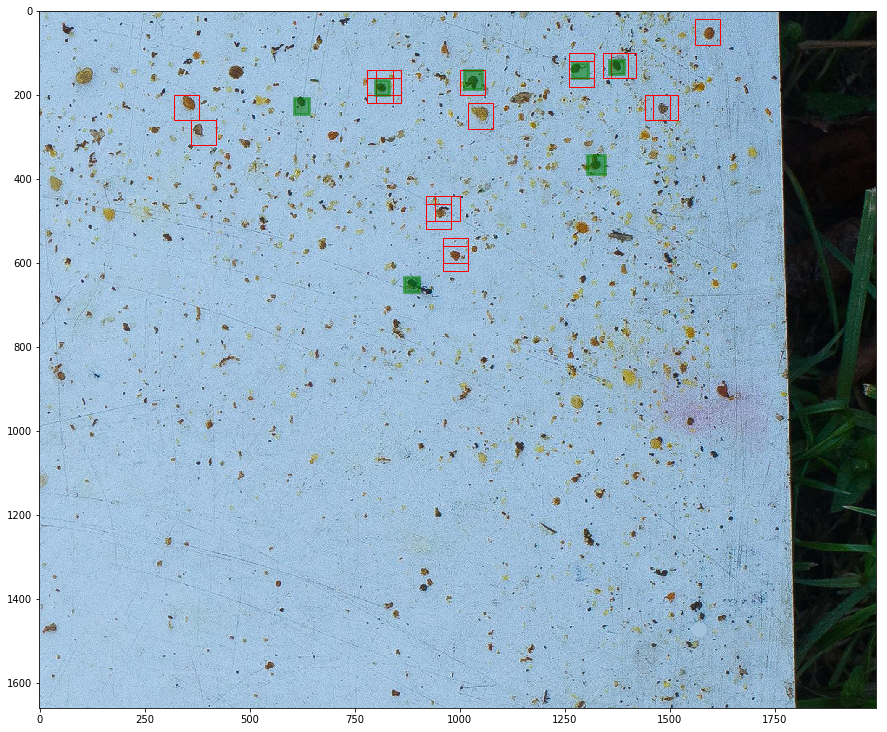

In [16]:
# contour extraction
contours = win_contours(labeled_wins, pos)
comp_contours = contours2complex(contours)
#display resuts
display_detection(use_img, labeled_wins, pos, contours=None, annotations=use_anno)

In [29]:
# useful to find the images with most varroas
length = [len(anno_train[i]) if i not in [23, 683, 114, 771] else 0 for i in range(len(anno_train))]
np.argmax(length)

286

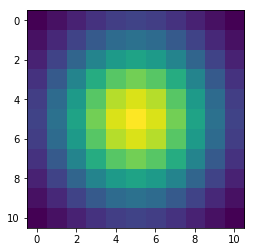

In [25]:
# gaussian kernel for correlation
size = 5
sigma = 3
x, y = np.meshgrid(np.arange(-size, size+1), 
                  np.arange(-size, size+1))

gaussian_kernel = 1 /(np.sqrt(2*np.pi)) /sigma *np.exp(-0.5 *(x**2 + y**2) /(sigma**2))
plt.imshow(gaussian_kernel)

In [30]:
#correlation with gaussian kernel
g = skimage.color.rgb2gray(use_img)
corr = correlate2d(g, 1-gaussian_kernel, boundary='symm')

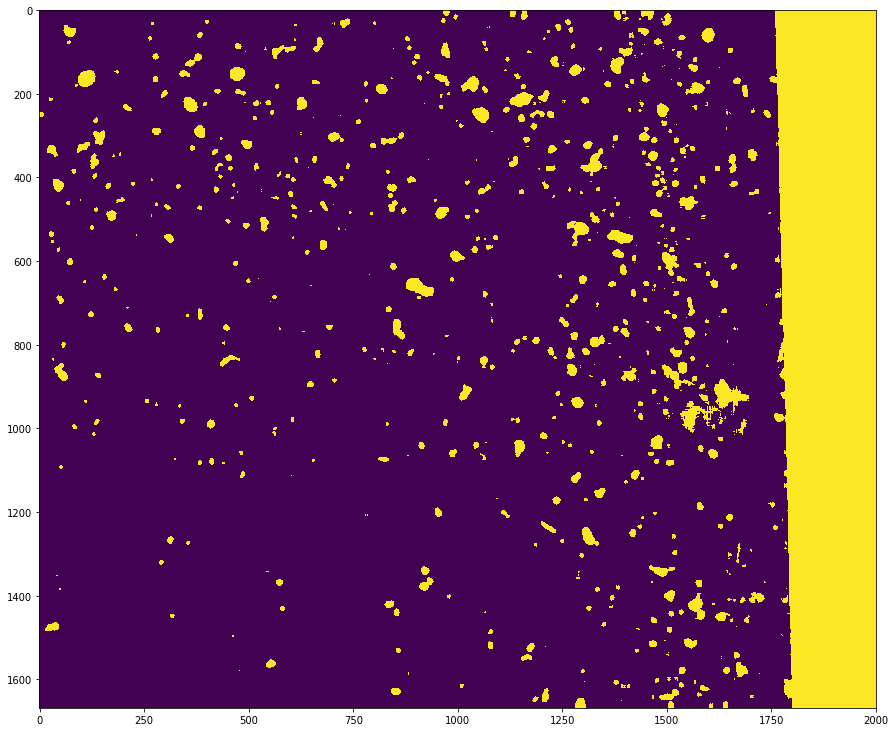

In [32]:
plt.figure(figsize=(15,15))
plt.imshow(corr, cmap='gray')
t = threshold_triangle(corr)
plt.imshow(corr < t)

In [18]:
from skimage.transform import rescale, resize, downscale_local_mean

# Extracts bbox around mites, nan padding

print("Extracting mites...")
dil = 0.3
mites_stack = []
for i, (img, anno_list) in enumerate(zip(im_train, anno_train)):
    print("\r{}".format(i), end=' '*10)
    if len(anno_list) > 0:
        for anno in anno_list: 
            x, y, x_len, y_len = anno['bbox']
            x = max(0, x-int(dil*x_len))
            y = max(0, y-int(dil*y_len))
            x_len = min(x_len+int(2*dil*x_len), img.shape[1])
            y_len = min(y_len+int(2*dil*y_len), img.shape[0])
            
            mites_stack.append([img[y:y+y_len, x:x+x_len][...,0], 
                                img[y:y+y_len, x:x+x_len][...,1], 
                                img[y:y+y_len, x:x+x_len][...,2]])
print("\rDone!"+' '*10)

max_size = [-1, -1]
for mite in mites_stack:
    max_size[0] = max(max_size[0], mite[0].shape[0])
    max_size[1] = max(max_size[1], mite[0].shape[1])
    
print("Max size of the bboxes: {}".format(max_size))

print("Rescaling...")
rescaled_mites_stack = np.full((len(mites_stack), 90, 90, 3), np.nan)
for i, mite in enumerate(mites_stack):
    print("\r{}".format(i), end=' '*10)
    y, x = mite[0].shape
    st_y, st_x = int(rescaled_mites_stack.shape[1] //2 -y//2), int(rescaled_mites_stack.shape[2] //2 -x//2)
    rescaled_mites_stack[i,st_y:st_y+y, st_x:st_x+x,0] = mite[0]
    rescaled_mites_stack[i,st_y:st_y+y, st_x:st_x+x,1] = mite[1]
    rescaled_mites_stack[i,st_y:st_y+y, st_x:st_x+x,2] = mite[2]
    
    
    
#     rescaled_mites_stack[i,...,0] = resize(mite[0], (90, 90))
#     rescaled_mites_stack[i,...,1] = resize(mite[1], (90, 90))
#     rescaled_mites_stack[i,...,2] = resize(mite[2], (90, 90))
                                     
print("\rDone!"+' '*10)

Extracting mites...
Done!                                                                                        
Max size of the bboxes: [83, 89]
Rescaling...
Done!                             


C:\Users\florian\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
C:\Users\florian\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
C:\Users\florian\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


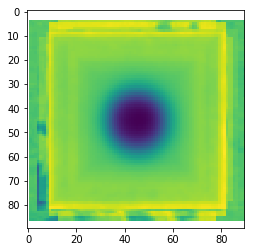

In [19]:
# mean image of mites for correlation 
mean_mite_r, mean_mite_g, mean_mite_b = np.nanmean(rescaled_mites_stack[...,0], axis=0), \
                                        np.nanmean(rescaled_mites_stack[...,1], axis=0), \
                                        np.nanmean(rescaled_mites_stack[...,2], axis=0)
plt.imshow(mean_mite_g)

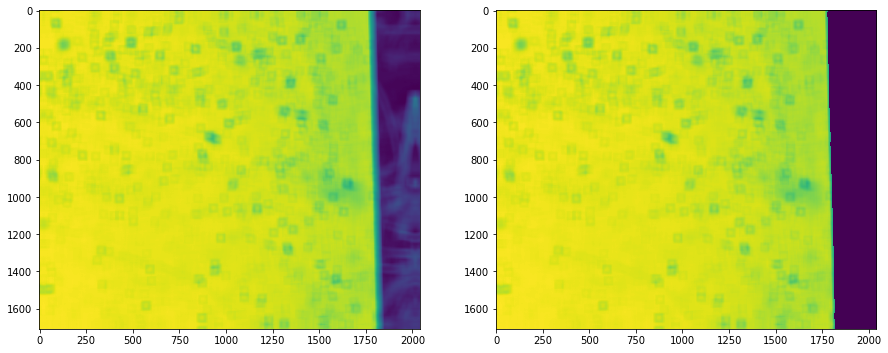

In [63]:
# corr = correlate2d(use_img[...,1], mean_mite_g[20:-20, 20:-20], boundary='symm')
plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.imshow(corr)
corr /= corr.max()

t = threshold_minimum(corr)
thr_img = (corr > t)

# t = threshold_triangle(corr *thr_img)
# thr_img = (thr_img > t)

plt.subplot(122)
plt.imshow(corr *thr_img)

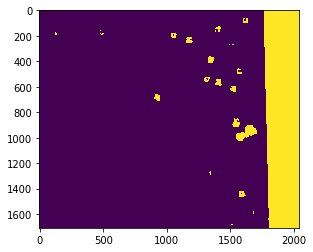

In [73]:
plt.imshow((corr *thr_img) < 0.80)

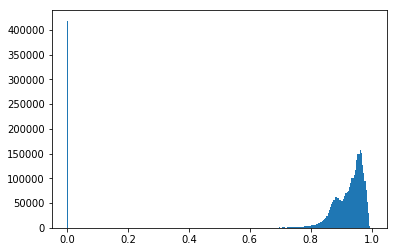

In [68]:
plt.hist((corr *thr_img).ravel(), bins=256);

In [60]:
(corr < threshold_triangle(corr *thr_img)).sum()

0

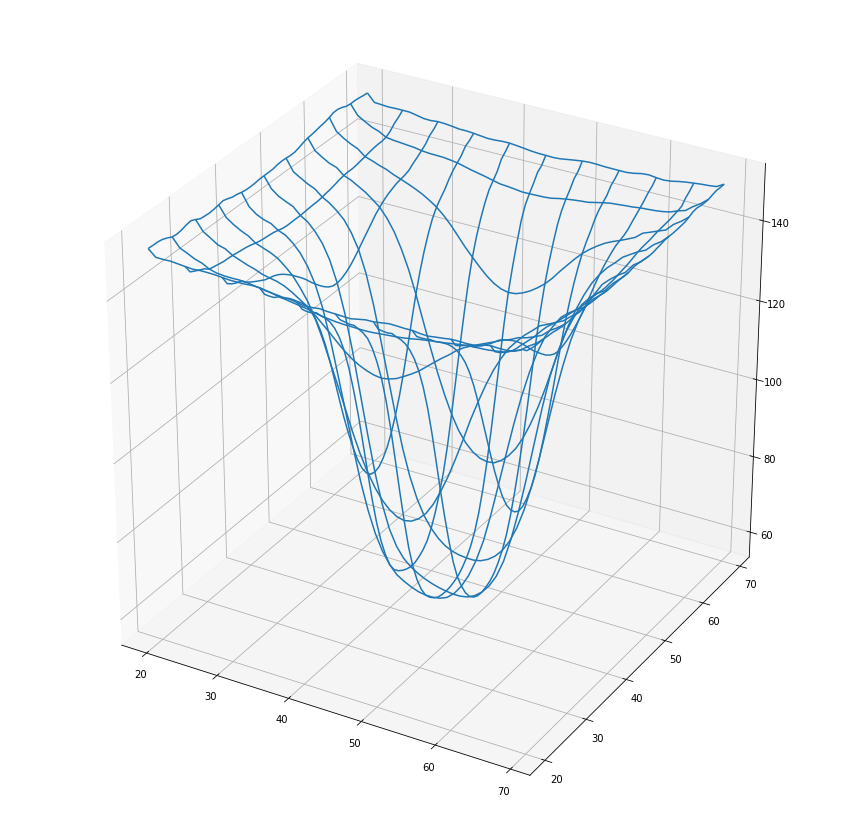

In [24]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(np.arange(0+20, 90-20), np.arange(0+20, 90-20))
ax.plot_wireframe(x, y, mean_mite_r[20:-20, 20:-20], rstride=5, cstride=5)

2236/2236

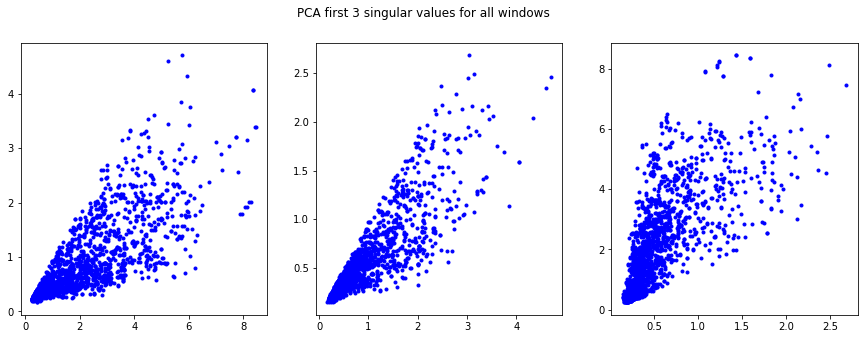

Morphological operations...            

C:\Users\florian\Anaconda3\lib\site-packages\skimage\segmentation\_clear_border.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True
C:\Users\florian\Anaconda3\lib\site-packages\skimage\segmentation\_clear_border.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True




2235    

45/45

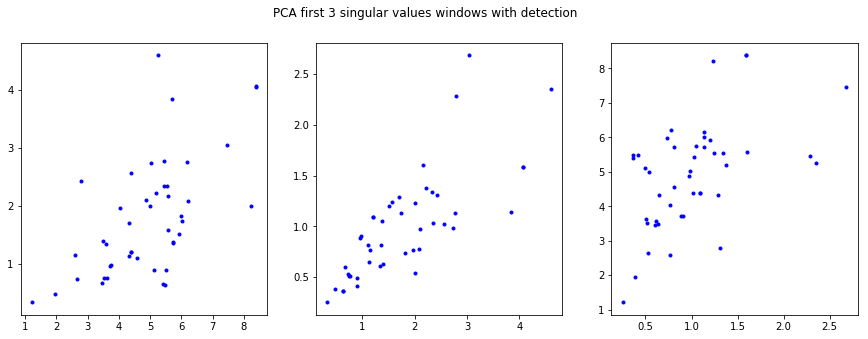

In [90]:
from sklearn.decomposition import PCA

# computes PCA on all windows then only on detection windows

def sliding_PCA(windows, n_comp=3):
    """Computes PCA analysis of all the given windows
        OUT:
            -n_comp singular values
    """
    grayscale = [skimage.color.rgb2gray(win) for win in windows]
    pca = PCA(n_components=n_comp)
    
    sing_vals = []
    for i, win in enumerate(grayscale):
        pca.fit(win)
        sing_vals.append(pca.singular_values_)
        print("\r{}/{}".format(i+1, len(windows)), end='')
    
    return sing_vals

use_img = im_train[0]
windows, pos = sliding_window((use_img), [75, 75], 30)

win_sing_vals = sliding_PCA(windows, 3)

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
plt.suptitle('PCA first 3 singular values for all windows ')

for s, s_val in enumerate(win_sing_vals):
    for i, ax in enumerate(axs.ravel()):
        ax.plot(s_val[i], s_val[(i+1)%3], 'b.')
        print("\r{}/{}".format(s+1, len(win_sing_vals)), end='')
        
plt.show()

labeled_wins, detection = thresholding_detection(windows, pos)

n_del =0
for i, detect in enumerate(detection):
    if not detect:
        print('\r{}    '.format(i), end='')
        del labeled_wins[i-n_del], windows[i-n_del], pos[i-n_del] 
        n_del +=1
else:
    print('\n')
    
win_sing_vals = sliding_PCA(windows, 3)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
plt.suptitle('PCA first 3 singular values windows with detection')

for s, s_val in enumerate(win_sing_vals):
    for i, ax in enumerate(axs.ravel()):
        ax.plot(s_val[i], s_val[(i+1)%3], 'b.')
        print("\r{}/{}".format(s+1, len(win_sing_vals)), end='')
        
plt.show()

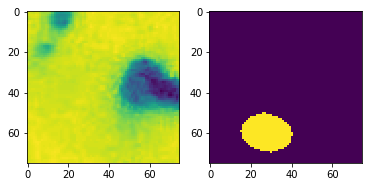

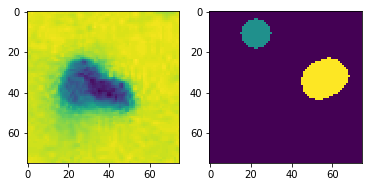

In [545]:
for i in range(len(labeled_win)):
    if (labeled_win[i] != 0).any():
        plt.subplot(121)
        plt.imshow(skimage.color.rgb2gray(windows[i]))
        plt.subplot(122)
        plt.imshow(labeled_win[i])
        plt.show()


In [275]:
def extract_bbox(image, annotation):
    bbox_windows = []
    for anno in annotation:
        bbox = anno['bbox']
        bbox_windows.append(image[ bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2], :])
    return bbox_windows


TypeError: Invalid dimensions for image data

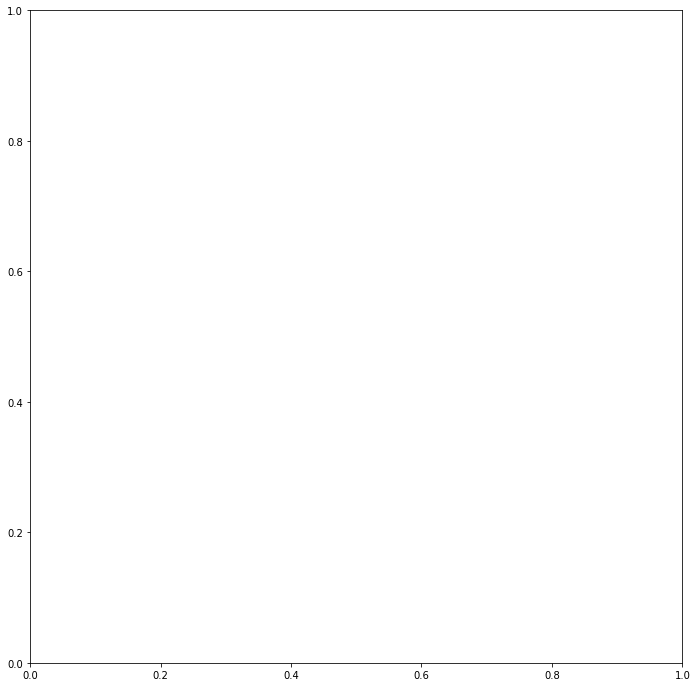

In [184]:
x = extract_bbox(im_train[1], anno_train[1])
x[0].shape
plot_images(x, anno_train[1], 'a', (1,1))


In [3]:
def detect_by_method_1(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [4]:
#Your code

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import skimage
import pickle

# Imports useful functions and the NN model
import Utilities
from model import *

net_filename = 'cnet_varroas_50_best.hdf5'

C:\Users\florian\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Building and training of a CNN

For the next part, we have decided to implement a convolutional net to classify the sliding windows. This method will use a LeNet architecture to classify the previously computed windows into two classes mites and no_mites.

This is supposed a classifier that could replace the one built in Part 2 with a better F1 score result. For the training we sampled windows in the training images that are classified with wether or not they intersect with one of the truth bbox from annotations.

In [2]:
TRAINING = False

if TRAINING:
    # Trains the model with the data
    train_set, train_target = Utilities.load_set_target('testing', 800, [50]*2, 15, bootstrap=False,  plot_sample=False)

    print("{} samples, {} channels".format(train_set.shape[0], train_set.shape[-1]))

    cnet = ConvNet(train_set.shape[1:])

    model_checkpoint = ModelCheckpoint(net_filename, monitor='loss', verbose=1, save_best_only=True)
    cnet.fit(train_set.astype(np.float32), train_target, batch_size=50, epochs=15, callbacks=[model_checkpoint])

else:
    # Loads the pretrained model
    cnet = load_model(net_filename)

#### Testing and predictions

For the prediction, we extract windows from the test images and get the class to which it should belong from the net. Then we can isolate the bboxes with mites in them from the others.
Since the net has a high recall and the windows have a small stride, we will predict multiple windows around a single mite. By creating a density plot on the image, we threshold and extract the origins of the detection with a fixed size bbox of the average bbox from the annotation.

In [5]:
# Testing the predictions of the model

im_test, anno_test, names = Utilities.load_images_annotations('testing')
show_stats = True


if show_stats:
    precision, recall, f1_score = [], [], []

test_pred = {}
detection_bboxes = []
for i, img in enumerate(im_test):
    print("\rImage: {}".format(i), end=' '*10)
    windows, positions = Utilities.sliding_window(img, [50]*2, 10)
    pred = cnet.predict(np.array(windows))

    pred_class = np.argmax(pred, axis=1)

    bboxes = Utilities.bbox_from_net_predictions(img, windows, positions, pred_class, anno_test[i], debug=False)
    test_pred[names[i]] = bboxes
    detection_bboxes.append(bboxes)

    if show_stats:
        p, r, f1 = Utilities.test_detection(bboxes, anno_test[i])
        precision.append(p)
        recall.append(r)
        f1_score.append(f1)

Image: 50              precision = 0.18, recall = 0.47, f1-score = 0.26


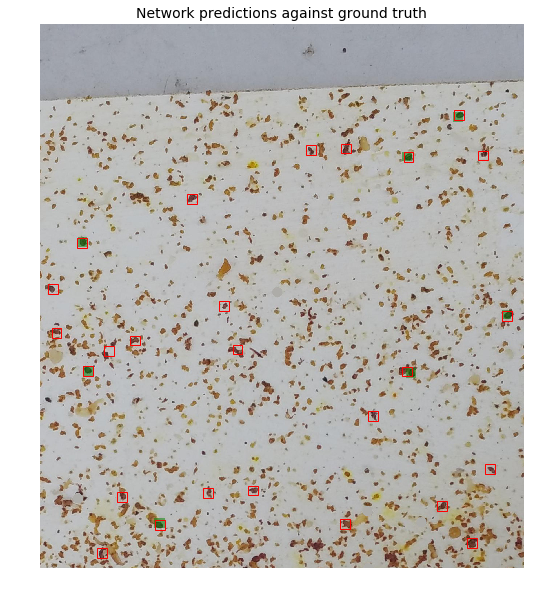

In [20]:
# plot_ind = 4, 6, 7, 8, 9
plot_ind = 9
windows, positions = Utilities.sliding_window(im_test[plot_ind], [50]*2, 10)
pred = cnet.predict(np.array(windows))

pred_class = np.argmax(pred, axis=1)

bboxes = Utilities.bbox_from_net_predictions(im_test[plot_ind], windows, 
                                             positions, pred_class, anno_test[plot_ind], debug=False)

Utilities.display_detection(im_test[plot_ind], windows=windows, pos=bboxes, contours=None, annotations=anno_test[plot_ind])
plt.axis('off')
plt.title('Network predictions against ground truth', fontsize=14);

One the above picture, we can see the predictions of the network (red boxes) and the ground truth (green rectangles). This is is an easy image to show the performance of the nets on images that aren't too noisy or cluttured.

Usually the recall is high when the mites are sparse but the prediction worsen when the mites are more clustered

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [6]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [7]:
# Predicts the bbox and the JSON file for the competition on EVAL_AI 
# Takes around 1h15

im_comp, names = Utilities.load_images_annotations('competiton')

comp_pred = {}
for i, img in enumerate(im_comp):
    print("\rImage: {}".format(i), end=' '*20)
    windows, positions = Utilities.sliding_window(img, [50]*2, 10)
    pred = cnet.predict(np.array(windows))

    pred_class = np.argmax(pred, axis=1)
    bboxes = Utilities.bbox_from_net_predictions(img, windows, positions, pred_class, competition=True)

    comp_pred[names[i]] = bboxes
    
    # Saves the predictions at each image in case of an issue
    pickle.dump(comp_pred, open('competition_predictions.pkl', mode='wb'))

Utilities.generate_pred_json(comp_pred, tag='test')